### Qcodes example notebook for Alazar card ATS9360 and acq controllers

In [1]:
import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.basic_controller as basic_aqc_contr
import qcodes.instrument_drivers.AlazarTech.samp_controller as samp_acq_contr
import qcodes.instrument_drivers.AlazarTech.samp as samp


import logging
logging.basicConfig(filename='example.log',level=logging.INFO)

qc.halt_bg()

No loop running


NB: See ATS9870 example notebook for general commands 

In [2]:
# Create the ATS9360 instrument
alazar = ATSdriver.AlazarTech_ATS9360(name='Alazar')
# Print all information about this Alazar card
alazar.get_idn()

{'CPLD_version': '25.16',
 'SDK_version': '5.9.25',
 'asopc_type': '1712554848',
 'bits_per_sample': 12,
 'driver_version': '5.9.25',
 'firmware': None,
 'latest_cal_date': '13-11-15',
 'max_samples': 4294967294,
 'memory_size': '4294967294',
 'model': 'ATS9360',
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8',
 'serial': '970344',
 'vendor': 'AlazarTech'}

In [3]:
# Configure all settings in the Alazar card
alazar.config(clock_source='EXTERNAL_CLOCK_10MHz_REF',
              sample_rate=500000000,
              clock_edge='CLOCK_EDGE_RISING',
              decimation=1,
              coupling=['DC','DC'],
              channel_range=[.4,.4],
              impedance=[50,50],
              trigger_operation='TRIG_ENGINE_OP_J',
              trigger_engine1='TRIG_ENGINE_J',
              trigger_source1='EXTERNAL',
              trigger_slope1='TRIG_SLOPE_POSITIVE',
              trigger_level1=140,
              trigger_engine2='TRIG_ENGINE_K',
              trigger_source2='DISABLE',
              trigger_slope2='TRIG_SLOPE_POSITIVE',
              trigger_level2=128,
              external_trigger_coupling='DC',
              external_trigger_range='ETR_2V5',
              trigger_delay=0,
              timeout_ticks=0,
              aux_io_mode='AUX_IN_AUXILIARY', # AUX_IN_TRIGGER_ENABLE for seq mode on
              aux_io_param='NONE' # TRIG_SLOPE_POSITIVE for seq mode on
             )

### Basic Acquisition

Pulls the raw data the alazar acquires averaged over number of records buffers.

In [4]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to.
basic_acq_controller = basic_aqc_contr.Basic_Acquisition_Controller(name='basic_acq_controller', 
                                                                    alazar_name='Alazar')

In [5]:
# Configure settings in the controller to be used in an acquisition
# nb this must be done before the first acquisition 
basic_acq_controller.update_acquisition_kwargs(samples_per_record=1024,
                                              records_per_buffer=1,
                                              buffers_per_acquisition=1,
                                              allocated_buffers=1
                                              )

In [6]:
# Pull data from the card by calling get of the controllers acquisition parameter
data1 = basic_acq_controller.acquisition()
print(data1)

(array([-0.00561661, -0.00659341, -0.00952381, ..., -0.00854701,
       -0.00659341, -0.0007326 ]), array([-0.0007326,  0.0021978,  0.001221 , ...,  0.001221 ,  0.001221 ,
        0.0031746]))


DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-18/15-50-34'
   <Type>   | <array_id>             | <array.name> | <array.shape>
   Measured | index0                 | index0       | (1024,)
   Measured | basic_acq_controller_A | A            | (1024,)
   Measured | basic_acq_controller_B | B            | (1024,)
acquired at 2017-01-18 15:50:34


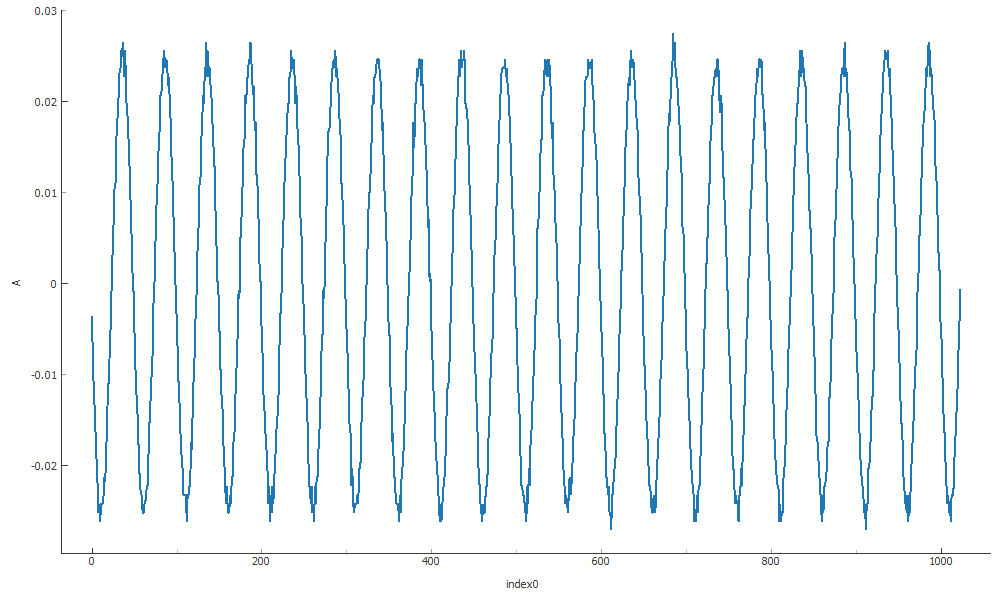

In [7]:
# Do this in as measurement (effactively the same but saves the data)
data2 = qc.Measure(basic_acq_controller.acquisition).run()
qc.QtPlot(data2.basic_acq_controller_A )

DataSet:
   mode     = DataMode.LOCAL
   location = '2017-01-18/15-50-47_AlazarTest'
   <Type>   | <array_id>             | <array.name> | <array.shape>
   Setpoint | dummy_set              | dummy        | (5,)
   Measured | index0                 | index0       | (5, 1024)
   Measured | basic_acq_controller_A | A            | (5, 1024)
   Measured | basic_acq_controller_B | B            | (5, 1024)
started at 2017-01-18 15:50:51


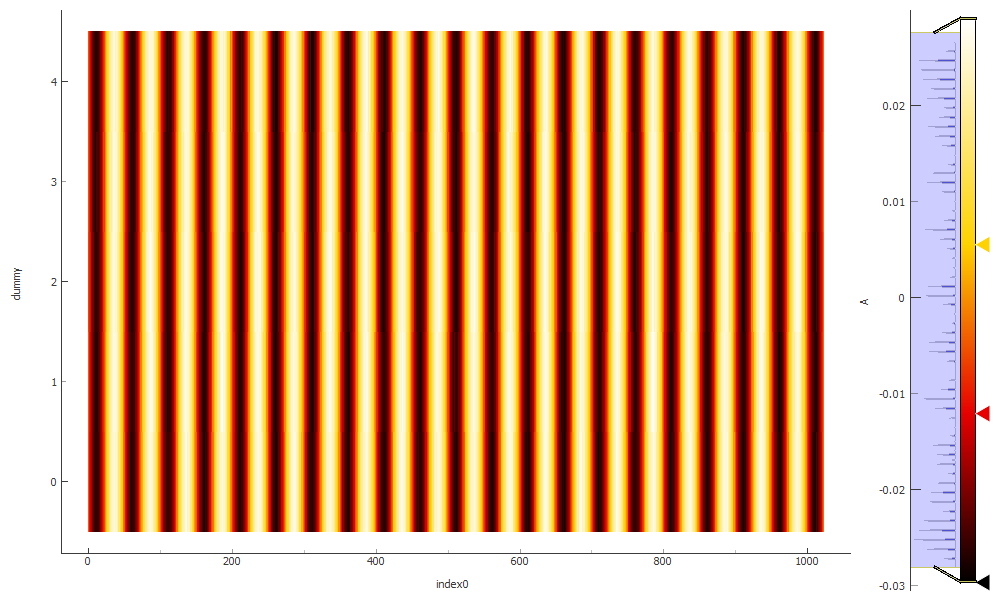

In [10]:
# Finally show that this instrument also works within a loop
dummy = parameter.ManualParameter(name="dummy")

data3 = qc.Loop(dummy[0:5:1]).each(basic_acq_controller.acquisition).run(name='AlazarTest')
qc.QtPlot(data3.basic_acq_controller_A)

### Samples Acquisition

This is the same as above except that it does some demodulation at the freqiencies specified

In [4]:
demod_list = [8e6, 9e6, 10e6, 11e6, 12e6]

In [5]:
# Create the acquisition controller which will take care of the data handling and tell it which 
# alazar instrument to talk to.
samp_acq_controller = samp_acq_contr.HD_Samples_Controller(name='samp_acq_controller', 
                                                           alazar_name='Alazar',
                                                          demod_freqs=demod_list)

In [16]:
# This command is specific to this acquisition controller. The kwargs provided here are being forwarded to ats_inst.acquire
# This way, it becomes easy to change acquisition specific settings from the ipython notebook
samp_acq_controller.update_acquisition_kwargs(
                 samples_per_record=1024,
                 records_per_buffer=1,
                 buffers_per_acquisition=1,
                 allocated_buffers=1
)

In [18]:
samp_acq_controller.demod_freq_3(20e6)
samp_acq_controller.demod_freq_1(1e6)

In [14]:
samp_acq_controller.update_filter_settings('win', 101)

In [13]:
#samp_acq_controller.demod_freq_0()
samp_acq_controller.int_delay(0)
m = samp_acq_controller.get_max_total_sample_time()
samp_acq_controller.int_time(m)

In [9]:
import numpy as np
l = np.ones(10)
m = np.arange(2)+1
q = np.kron(m,l).reshape(len(m), len(l))
print(q)
print(q.shape)
r = np.kron(np.ones(2), np.arange(10)).reshape(len(m), len(l))
print(r)
print(r.shape)
a = np.multiply(q, r)
print(a)
print(a + a * 1j)
print(abs(a + a * 1j))

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]]
(2, 10)
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]]
(2, 10)
[[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.]
 [  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.]]
[[  0. +0.j   1. +1.j   2. +2.j   3. +3.j   4. +4.j   5. +5.j   6. +6.j
    7. +7.j   8. +8.j   9. +9.j]
 [  0. +0.j   2. +2.j   4. +4.j   6. +6.j   8. +8.j  10.+10.j  12.+12.j
   14.+14.j  16.+16.j  18.+18.j]]
[[  0.           1.41421356   2.82842712   4.24264069   5.65685425
    7.07106781   8.48528137   9.89949494  11.3137085   12.72792206]
 [  0.           2.82842712   5.65685425   8.48528137  11.3137085
   14.14213562  16.97056275  19.79898987  22.627417    25.45584412]]


In [10]:
abs(-0.00757021 +3.70833219e-18j)

0.00757021

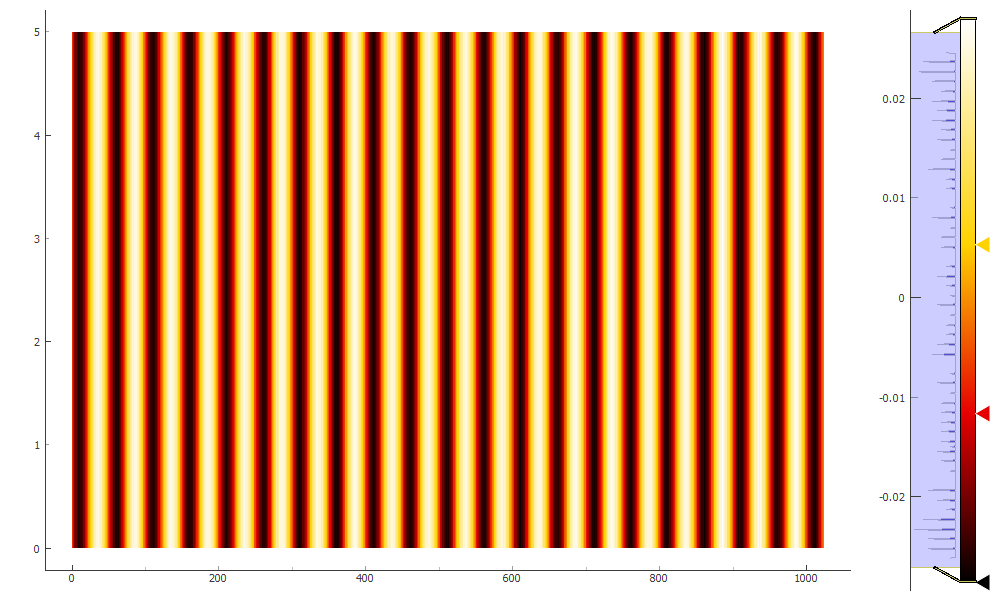

In [17]:
qc.QtPlot(data3[1])

[ -2.26076671e-04 +1.43245960e-04j  -2.09100829e-04 -1.24897611e-05j
  -2.82206438e-03 -1.12859796e-02j   5.19305390e-05 -4.73969948e-05j
   1.28242477e-04 +2.39117361e-05j]
[ 0.00541151  0.00083713  0.01163864  0.00025246  0.00532936]
[  -6.36968084   -6.4322607  -104.8868904   -13.69649501   -2.72335652]
> a:\qcodes\qcodes\instrument_drivers\alazartech\samp_controller.py(393)fit()
-> return magnitude, volt_rec_mat
(Pdb) c


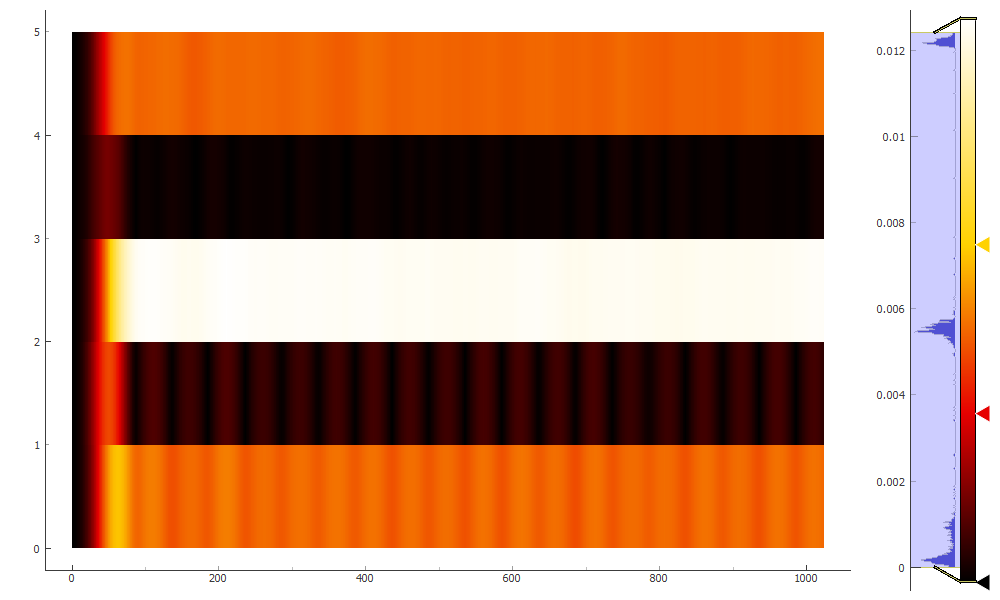

In [19]:
data3 = samp_acq_controller.acquisition()
qc.QtPlot(data3[0])

In [12]:
abs(-0.00558072-0.00063387*1j)

0.005616602789524999

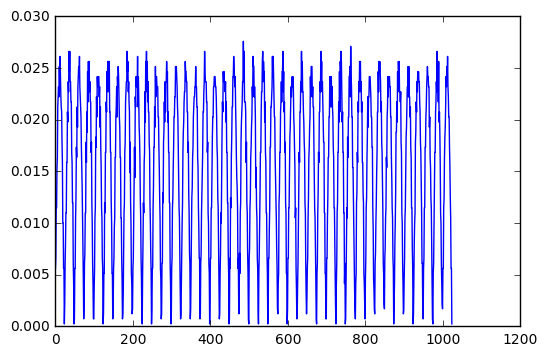

In [20]:
fig = plt.figure()
plt.plot(data3[0][1])
plt.show()

In [42]:
abs(0.00093215 -8.04502014e-05*1j)

0.0009356152293572932

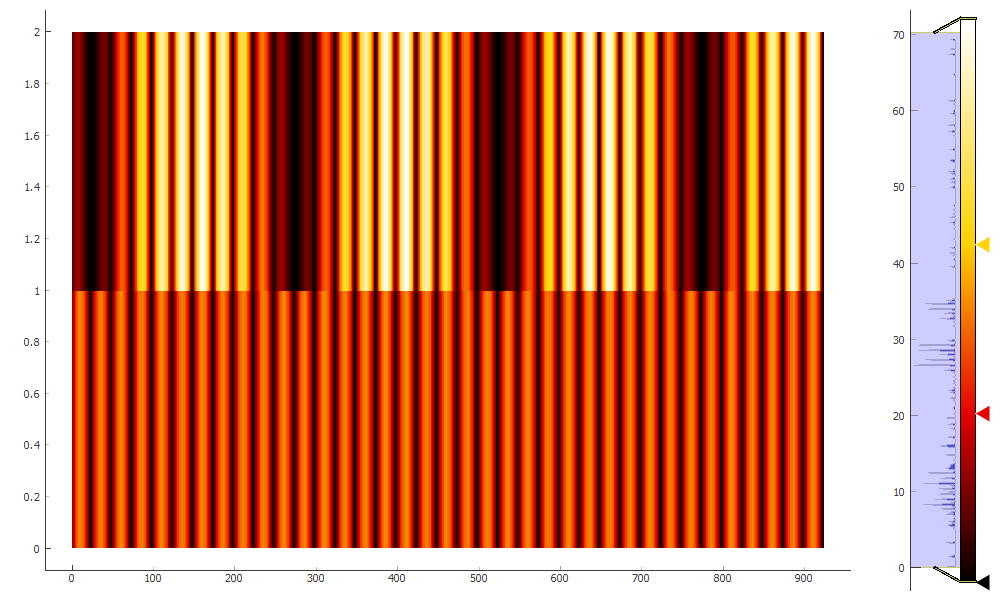

In [51]:
samp_acq_controller.demod_freq_1(11e6)
samp_acq_controller.demod_freq_0(9e6)
data3 = samp_acq_controller.acquisition()
qc.QtPlot(data3[0])

In [10]:
data4 = qc.Measure(samp_acq_controller.acquisition).run()

ValueError: nth setpoint array should have shape matching the first n dimensions of shape.

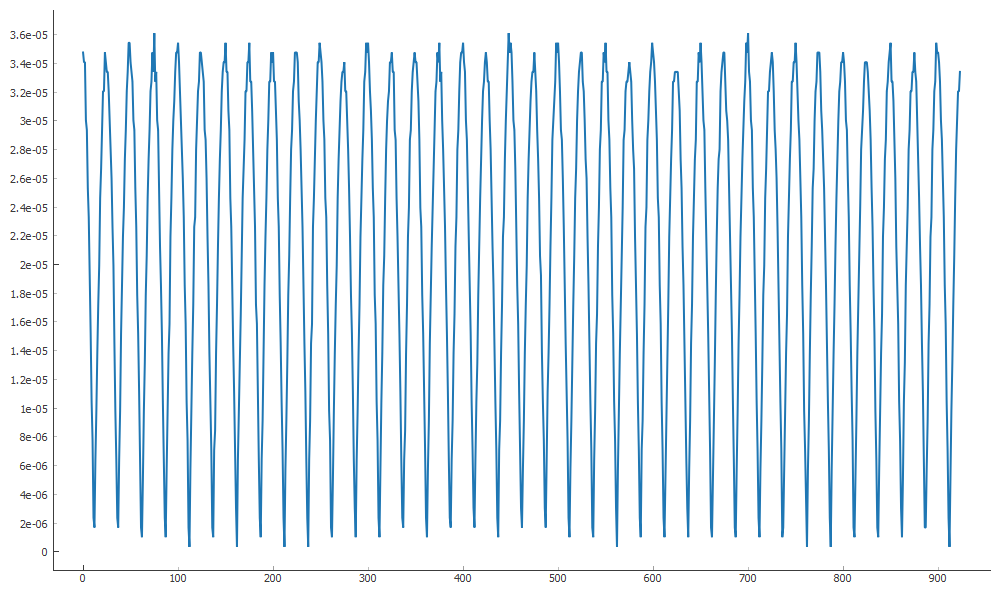

In [22]:
qc.QtPlot(data4.samp_acq_controller_magnitude[0])

In [20]:
dummy = parameter.ManualParameter(name="dummy")
data4 = qc.Loop(dummy[0:5:1]).each(
    samp_acq_controller.acquisition).run(name='AlazarTest')

ValueError: nth setpoint array should have shape matching the first n dimensions of shape.

In [ ]:
dummy = parameter.ManualParameter(name="dummy")
data4 = qc.Loop(samp_acq_controller.demod_freq_0.sweep(9e6, 10e6, 1e6)).each(
    samp_acq_controller.acquisition).run(name='AlazarTest')

In [23]:
qc.QtPlot(data4.samples_controller_magnitude)

NameError: name 'data4' is not defined

In [24]:
import qcodes.instrument_drivers.AlazarTech.ave_controller as single_controller

sing_contr = single_controller.HD_Controller(name='single_controller', 
                                             alazar_name='Alazar1', 
                                             demod_freq = 5e6,
                                             server_name="alazar_server")

a:\qcodes\qcodes\instrument\metaclass.py:37: UserWarning: Multiprocessing is in beta, use at own risk
  UserWarning)


In [25]:
# This command is specific to this acquisition controller. The kwargs provided here are being forwarded to ats_inst.acquire
# This way, it becomes easy to change acquisition specific settings from the ipython notebook
sing_contr.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=2560,
                 records_per_buffer=1,
                 buffers_per_acquisition=1,
                 allocated_buffers=1,
)

In [30]:
dummy = parameter.ManualParameter(name="dummy")
data6 = qc.Loop(dummy[0:5:1]).each(
    sing_contr.acquisition).run(name='AlazarTest')

DataSet:
   mode     = DataMode.LOCAL
   location = '2016-11-08/10-27-15_AlazarTest'
   <Type>   | <array_id>                  | <array.name> | <array.shape>
   Setpoint | dummy_set                   | dummy        | (5,)
   Measured | single_controller_magnitude | magnitude    | (5,)
   Measured | single_controller_phase     | phase        | (5,)
started at 2016-11-08 10:27:17


In [13]:
qc.QtPlot(data6.single_controller_phase)

In [ ]:
# Configure settings on Alazar card for sequencing mode (ie use aux i/o for triggering as well)
ats_inst.config(clock_source='EXTERNAL_CLOCK_10MHz_REF',
                sample_rate='10MHZ_REF_500MSPS',
                clock_edge='CLOCK_EDGE_RISING',
                decimation=1,
                coupling=['DC','DC'],
                channel_range=[.4,.4],
                impedance=[50,50],
                trigger_operation='TRIG_ENGINE_OP_J',
                trigger_engine1='TRIG_ENGINE_J',
                trigger_source1='EXTERNAL',
                trigger_slope1='TRIG_SLOPE_POSITIVE',
                trigger_level1=140,
                trigger_engine2='TRIG_ENGINE_K',
                trigger_source2='DISABLE',
                trigger_slope2='TRIG_SLOPE_POSITIVE',
                trigger_level2=128,
                external_trigger_coupling='DC',
                external_trigger_range='ETR_2V5',
                trigger_delay=0,
                timeout_ticks=0,
                aux_io_mode='AUX_IN_TRIGGER_ENABLE', 
                aux_io_param='TRIG_SLOPE_POSITIVE'
)

In [11]:
import qcodes.instrument_drivers.AlazarTech.rec_controller as record_controller

rec_contr = record_controller.HD_Records_Controller(name='rec_controller', 
                                                      alazar_name='Alazar1', 
                                                      demod_freq = 5e6,
                                                      server_name="alazar_server")

a:\qcodes\qcodes\instrument\metaclass.py:37: UserWarning: Multiprocessing is in beta, use at own risk
  UserWarning)


In [12]:
# This command is specific to this acquisition controller. The kwargs provided here are being forwarded to ats_inst.acquire
# This way, it becomes easy to change acquisition specific settings from the ipython notebook
rec_contr.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=1024,
                 records_per_buffer=20,
                 buffers_per_acquisition=1,
                 allocated_buffers=1,
)

<IPython.core.display.Javascript object>


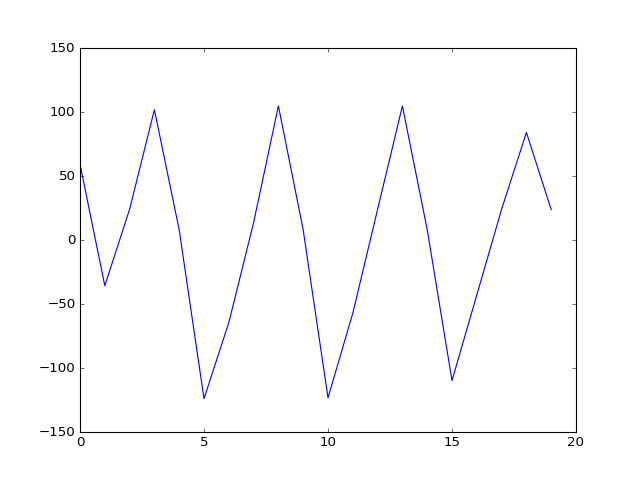

In [15]:
data7 = rec_contr.acquisition()
qc.MatPlot(data7[1])

In [16]:
dummy = parameter.ManualParameter(name="dummy")
data8 = qc.Loop(dummy[0:5:1]).each(
    rec_contr.acquisition).run(name='AlazarTest')

DataSet:
   mode     = DataMode.LOCAL
   location = '2016-11-08/11-29-47_AlazarTest'
   <Type>   | <array_id>               | <array.name> | <array.shape>
   Setpoint | dummy_set                | dummy        | (5,)
   Measured | record_num               | record_num   | (5, 20)
   Measured | rec_controller_magnitude | magnitude    | (5, 20)
   Measured | rec_controller_phase     | phase        | (5, 20)
started at 2016-11-08 11:29:49


In [17]:
qc.QtPlot(data8.rec_controller_magnitude)